# Initialization

In [1]:
import sys
sys.path.append("/media/hdd/viscent/SR-UNet")
from utils.inference_utils import *
from geomloss import SamplesLoss
from skopt import gp_minimize
import torchvision
import kornia as K
import functools
from skopt.plots import plot_convergence

In [4]:
%%capture
dhcp_train_loader, dhcp_test_loader, dhcp_val_loader = get_dataloader('dhcp',20,modality='t2')
# hcp_train_loader, hcp_test_loader, hcp_val_loader = get_dataloader('hcp',20,modality='t2')

In [2]:
data_root = '/media/hdd/viscent/FLYWHEEL_BROWN/BROWN/SUBJECTS'
subject_list = os.listdir(data_root)
# Exclude hidden files
subject_list = [x for x in subject_list if not x.startswith('.') and x.startswith('MM')]
t2_file_list = []
for subject in subject_list:
    tmp = os.listdir(os.path.join(data_root, subject, 'SESSIONS'))
    tmp = [x for x in tmp if not x.startswith('.')]
    session = tmp[0]
    tmp = os.listdir(os.path.join(data_root, subject, 'SESSIONS', session, 'ACQUISITIONS'))
    tmp = [x for x in tmp if x.find('T2') != -1 and x.find('AXI') != -1 and not x.startswith('.')]
    if len(tmp) == 0:
        continue
    nifti_dir = os.path.join(data_root, subject, 'SESSIONS', session, 'ACQUISITIONS', tmp[0], 'FILES')
    nifti_file = os.listdir(nifti_dir)
    nifti_file = [x for x in nifti_file if x.endswith('.nii.gz') and not x.startswith('.')][0]
    t2_file_list.append(os.path.join(nifti_dir, nifti_file))


In [4]:
%%capture
model = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/unet_dhcp_t2/1600.pth')
model.eval()
model.cuda()

# Preprocessing

## Brain extraction

In [35]:
import shutil

for i,t2_file in tqdm(enumerate(t2_file_list),total=len(t2_file_list)):
    shutil.copy(t2_file, '/media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/raw/%03d.nii.gz'%i)
    os.system('hd-bet -i /media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/raw/%03d.nii.gz -o /media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/brain/%03d.nii.gz'% (i,i))

  0%|          | 0/64 [00:00<?, ?it/s]


########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/raw/000.nii.gz
preprocessing...
image shape after preprocessing:  (120, 145, 119)
prediction (CNN id)...
0
1
2
3
4
running postprocessing... 
exporting segmentation...

########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /

In [28]:
img_brown.CopyInformation

(-0.9999999999999996,
 0.0,
 3.422854177870248e-08,
 0.0,
 -1.0,
 0.0,
 3.422854177870248e-08,
 0.0,
 0.9999999999999996)

In [27]:
img_dhcp = sitk.ReadImage("/media/hdd/dhcp/dhcp_hires/images_t2/sub-CC01018XX12_ses-46130_T2w_brain.nii.gz")

<Figure size 1440x720 with 0 Axes>

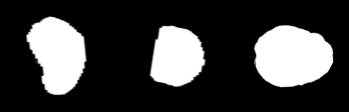

<Figure size 1440x720 with 0 Axes>

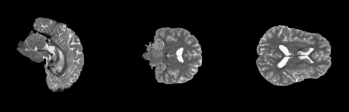

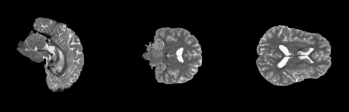

In [52]:
img_brown = sitk.ReadImage("/media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/reg/013.nii.gz")
img_dhcp = sitk.ReadImage("/media/hdd/viscent/SR-UNet_bkp/inference/Template_dHCP.nii.gz")
# _,img_dhcp = iter(dhcp_train_loader).__next__()
img_brown.SetDirection(img_dhcp.GetDirection())
# array_brown = sitk.GetArrayFromImage(img_brown).transpose(2,1,0)
# img_brown_ = sitk.GetImageFromArray(array_brown)
# img_brown_.CopyInformation(img_brown)
# img_brown = img_brown_
display_multiplanar_center(sitk.GetArrayFromImage(img_brown))
display_multiplanar_center(sitk.GetArrayFromImage(img_dhcp))

## Registration

In [38]:
for i in range(64):
    os.system('flirt -searchrx -15 15 -searchry -15 15 -searchrz -15 15 -in /media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/brain/%03d.nii.gz -ref /media/hdd/viscent/SR-UNet_bkp/inference/Template_dHCP.nii.gz -out /media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/reg/%03d.nii.gz'% (i,i))


Final result: 
0.149268 -0.131497 -0.745702 132.611829 
0.012397 0.735624 -0.134157 11.942590 
0.717028 0.027307 0.199969 4.256724 
0.000000 0.000000 0.000000 1.000000 


Final result: 
-0.045699 -0.008965 -0.699997 142.986407 
-0.013559 0.744731 0.023069 -0.835392 
0.720971 0.032369 0.006577 15.505877 
0.000000 0.000000 0.000000 1.000000 


Final result: 
-0.142314 -0.072706 -0.741743 152.893542 
0.010843 0.702454 -0.130851 14.073728 
0.721191 -0.022329 -0.106121 23.209388 
0.000000 0.000000 0.000000 1.000000 


Final result: 
-0.049661 -0.015491 -0.743954 145.426921 
-0.004078 0.747371 -0.030286 5.789320 
0.722329 0.017201 -0.015084 19.342599 
0.000000 0.000000 0.000000 1.000000 


Final result: 
-0.074932 -0.019954 -0.663509 149.812860 
0.134046 0.722699 -0.020058 -8.144139 
0.678966 -0.092571 -0.019373 34.852681 
0.000000 0.000000 0.000000 1.000000 


Final result: 
-0.020802 0.001983 -0.748816 164.321657 
0.010817 0.795625 0.035601 -5.090706 
0.669160 -0.033645 -0.005450 24.06209

Image Exception : #63 :: No image files match: /media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/brain/064
Image Exception : #22 :: Failed to read volume /media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/brain/064.nii.gz
Error : No image files match: /media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/brain/064
Failed to read volume /media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/brain/064.nii.gz
Error : No image files match: /media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/brain/064
Image Exception : #63 :: No image files match: /media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/brain/065
Image Exception : #22 :: Failed to read volume /media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/brain/065.nii.gz
Error : No image files match: /media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/brain/065
Failed to read volume /media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/brain/065.nii.gz
Error : No image files match: /media/hdd/viscent/FLYWHEEL_BROWN/Preprocessed/brain/065
Image Exception : #63 :: No image files match: /me

# Formatting

In [11]:
images = []
image_tensors = []
t2_file_list = os.listdir('/media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_BROWN/input_reg/')
t2_file_list = [os.path.join('/media/hdd/viscent/SR-UNet/inference/Inference_FLYWHEEL_BROWN/input_reg/',x) for x in t2_file_list]
for t2_file in tqdm(t2_file_list,total=len(t2_file_list)):
    images.append(sitk.ReadImage(t2_file))
    subject = tio.Subject(t2=tio.ScalarImage(t2_file))
    transform_1 = tio.Compose([
        tio.transforms.RescaleIntensity((0., 1.)),
        tio.transforms.ToCanonical(),
        tio.transforms.Resample((1.,1.,1.)),
    ])
    subject = transform_1(subject)
    edge_max = max(subject.t2.data.shape)
    padding = ((edge_max - subject.t2.data.shape[1]) // 2, 
                (edge_max - subject.t2.data.shape[2]) // 2,
                    (edge_max - subject.t2.data.shape[3]) // 2)
    transform_2 = tio.Compose([
        tio.Pad(padding),
        tio.transforms.Resize((160,160,160)),
    ])
    image_tensor = transform_2(subject).t2.data.unsqueeze(0)
    image_tensors.append(image_tensor)

  0%|          | 0/113 [00:00<?, ?it/s]

# Optimization

IndexError: list index out of range

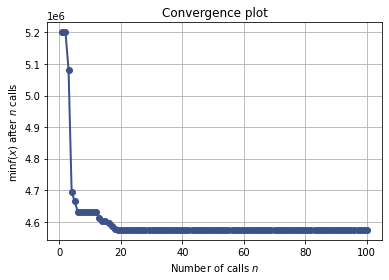

In [18]:
latent_train = torch.load('/media/hdd/viscent/SR-UNet/dev/latent_dhcp.pt').cuda()
def objective(x, latent_train, image_tensor):
    image_tensor = K.enhance.adjust_gamma(image_tensor,x[0])
    image_tensor = K.enhance.sharpness(image_tensor,x[1])
    latent_input = kl_forward_latent(model, image_tensor.cuda())
    latent_input = latent_input.flatten().unsqueeze(0)
    latent_train = latent_train.flatten(start_dim=1)
    loss = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.95)(latent_input, latent_train)
    return loss.item()
_objective = functools.partial(objective, latent_train=latent_train, image_tensor=image_tensors[0])

res = gp_minimize(_objective,                  # the function to minimize
                  [(1e-6, 2.0),(1e-1,1.)],      # the bounds on each dimension of x
                  n_calls=100,         # the number of evaluations of f
                  noise=0.001,   
                random_state=1234)  # the seed

plot_convergence(res)
image_opti = K.enhance.adjust_gamma(image_tensor,res.x[0])
image_opti = K.enhance.adjust_brightness(image_opti,res.x[1])
display_multiplanar_center(image_tensors[0][0,0,:,:,:].cpu().numpy())
display_multiplanar_center(image_opti[0,0,:,:,:].cpu().numpy())

# Generating Latents

## Vanilla

In [14]:
latent_brown = []
for img in tqdm(image_tensors):
    img = img.cuda()
    with torch.no_grad():
        latent_brown.append(kl_forward_latent(model,img))
latent_brown = torch.cat(latent_brown,dim=0)
torch.save(latent_brown,'/media/hdd/viscent/SR-UNet/dev/latent_brown.pt')

  0%|          | 0/113 [00:00<?, ?it/s]

## Optimized

In [16]:
def process_and_forward(model, image_tensor, res):
    image_tensor = K.enhance.adjust_gamma(image_tensor,res.x[0])
    image_tensor = K.enhance.adjust_brightness(image_tensor,res.x[1])
    image_tensor = K.enhance.sharpness(image_tensor,res.x[2])
    image_tensor = image_tensor.cuda()
    with torch.no_grad():
        latent = kl_forward_latent(model, image_tensor)
    return latent

latent_brown_opti = []
for img in tqdm(image_tensors):
    latent_brown_opti.append(process_and_forward(model, img, res))
latent_brown_opti = torch.cat(latent_brown_opti,dim=0)
torch.save(latent_brown_opti,'/media/hdd/viscent/SR-UNet/dev/latent_brown_opti.pt')

  0%|          | 0/113 [00:00<?, ?it/s]

<Figure size 1440x720 with 0 Axes>

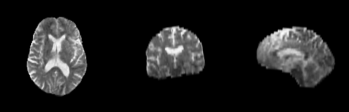

<Figure size 1440x720 with 0 Axes>

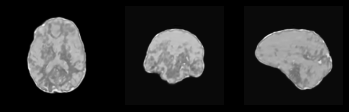

<Figure size 1440x720 with 0 Axes>

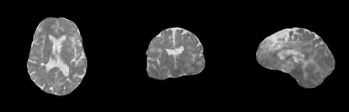

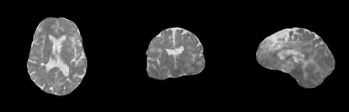

In [17]:
output_opti = model(image_opti.cuda())
output_vanilla = model(image_tensors[0].cuda())
output_opti = output_opti.cpu().detach().numpy()
output_vanilla = output_vanilla.cpu().detach().numpy()
display_multiplanar_center(image_tensors[0][0,0,:,:,:])
display_multiplanar_center(output_opti[0,0,:,:,:])
display_multiplanar_center(output_vanilla[0,0,:,:,:])